In [27]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.ticker as mticker
from multiprocessing import Pool
from tqdm import tqdm, tqdm_notebook
from time import sleep

In [28]:
def simulate_single_run(args):
    num_cards, hand_perc, stop_percentage = args
    hand_size = int(num_cards * hand_perc)
    hand = np.random.choice(range(1, num_cards+1), hand_size, replace=False)
    max_card = 0
    max_index = np.argmax(hand)
    for card_index, card in enumerate(hand):
        if card_index > max_index:
            # If we have passed on the max card, we can't win, so exit early.
            return False
        if card > max_card:
            # Update the card to be the new maximum
            max_card = card

            num_cards_left_in_hand = hand_size - (card_index + 1)
            num_lower_cards = (card - 1) - card_index

            # For this card to possibly be the highest, there
            # needs to be fewer cards left in our hand than there
            # are lower than our number.
            if num_cards_left_in_hand <= num_lower_cards:

                # The probability that all the remaining cards in our hand is lower
                # is the combined probability of drawing those remaining cards.
                sub = np.arange(num_cards_left_in_hand)
                num = np.full(num_cards_left_in_hand, num_lower_cards) - sub
                denom = np.full(num_cards_left_in_hand, num_cards - (card_index+1)) - sub
                frac = num / denom
                prob_all_lower = np.prod(frac)
                if prob_all_lower >= stop_percentage:
                    return card == max(hand)

In [29]:
def simulate_single_stop_percentage(num_cards, hand_perc, stop_percentage, sample_size):
    result = []
    with Pool(processes=4) as p:
        with tqdm_notebook(total=sample_size, leave=False) as pbar:
            for r in p.imap_unordered(simulate_single_run,
                                      itertools.repeat((num_cards, hand_perc, stop_percentage),
                                                       sample_size)):
                pbar.update(1)
                result.append(r)
    return Counter(result)[True] / sample_size

In [30]:
def simulate_multiple_stop_percentages(num_cards, hand_perc, stop_percentages, sample_size):
    result = []
    for i in tqdm_notebook(range(len(stop_percentages)), leave=False):
        result.append(simulate_single_stop_percentage(num_cards,
                                                      hand_perc,
                                                      stop_percentages[i],
                                                      sample_size))
    return result

In [31]:
NUM_CARDS = 100
HAND_PERC = .10
STOP_PERCS = np.linspace(0,1,num=51)
SAMPLE_SIZE = 50000

win_pct = simulate_multiple_stop_percentages(NUM_CARDS, HAND_PERC, STOP_PERCS, SAMPLE_SIZE)

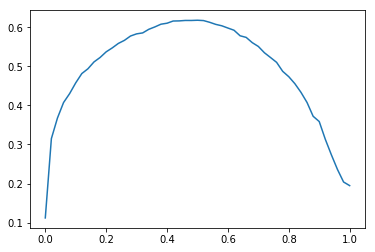

In [32]:
plt.plot(STOP_PERCS, win_pct)
plt.show()

In [33]:
STOP_PERCS[win_pct.index(max(win_pct))]

0.5

In [34]:
NUM_CARDS = 100
HAND_PERC = np.linspace(0.1,0.9,num=9)
STOP_PERCS = np.linspace(0,1,num=26)
SAMPLE_SIZE = 50000

hand_percentages = np.linspace(0.1,0.9,num=9)
percentages = np.linspace(0,1,num=26)

win_pcts=[]

for perc in tqdm_notebook(HAND_PERC, leave=False):
    win_pcts.append(simulate_multiple_stop_percentages(NUM_CARDS, perc, STOP_PERCS, SAMPLE_SIZE))

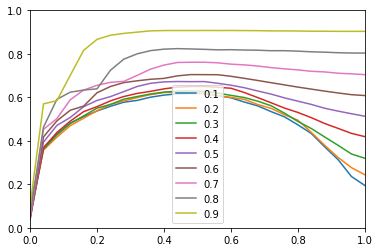

In [35]:
for label, win_pct in zip(HAND_PERC, win_pcts):
    plt.plot(percentages, win_pct, label=label)

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend()
plt.show()